In [1]:
#These are the libraries you can use.  You may add any libraries directy related to threading if this is a direction
#you wish to go (this is not from the course, so it's entirely on you if you wish to use threading).  Any
#further libraries you wish to use you must email me, james@uwaterloo.ca, for permission.

from IPython.display import display, Math, Latex

import pandas as pd
import numpy as np
import numpy_financial as npf
import yfinance as yf
import matplotlib.pyplot as plt
import random
from datetime import datetime, timedelta

## Group Assignment
### Team Number: 05
### Team Member Names: James Begin, Jonathan Wen, Emily Qi
### Team Strategy Chosen: Market Meet

Disclose any use of AI for this assignment below (detail where and how you used it).  Please see the course outline for acceptable uses of AI.


## Contribution Declaration

The following team members made a meaningful contribution to this assignment:

Insert Names Here.

# Introduction 
The goal of the market "meet" portfolio is to match the returns of the average of the TSX60 and S&P500 indices as closely as possibly. To do this, we look at various indicators that can provide insight into a stock's ability to match market returns. Below are the factors we plan to take into account while constructing our portfolio:  
- Volume
- Price
- Beta
- Market Cap
- Earnings and Dividend Dates
- Fund/Institutional Holdings  

## Filtering
First, we ignore any delisted stocks, or non-US and Canadian Stocks, then filter by average monthly volume:
  



In [2]:
tickers = pd.read_csv('Tickers_Example.csv')
tickerlist = [tickers.columns[0]]
tickerlist += [i for i in tickers.iloc[:,0]]
startdate = '2023-10-01'
enddate = '2024-09-30'
stockdata = yf.download(tickerlist, start=startdate, end=enddate)
delisted = list(yf.shared._ERRORS.keys())
for i in delisted:
    tickerlist.remove(i)
    
exchangelist = ['NMS', 'NYQ', 'TOR']
minprice = 5
minvolume = 100000

for ticker in tickerlist:
    t = yf.Ticker(ticker)
    hist = t.history(start=startdate, end=enddate, period='1mo')
    if (t.get_history_metadata())['exchangeName'] not in exchangelist or hist['Volume'].mean() < minvolume or hist['Close'].mean() < minprice:
        tickerlist.remove(ticker)    

[*********************100%***********************]  41 of 41 completed

4 Failed downloads:
['RTN', 'MON', 'CELG', 'AGN']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')


## Earnings Dates and Dividends
The period surrounding Earnings Dates, and Dividend Dates typically bring about higher volatility as investors and speculators buy and sell, hoping to take advantage of upcoming news and guidance. Below we illustrate some of the effects of Earnings/Corporate Announcements on volatility.


<BarContainer object of 2 artists>

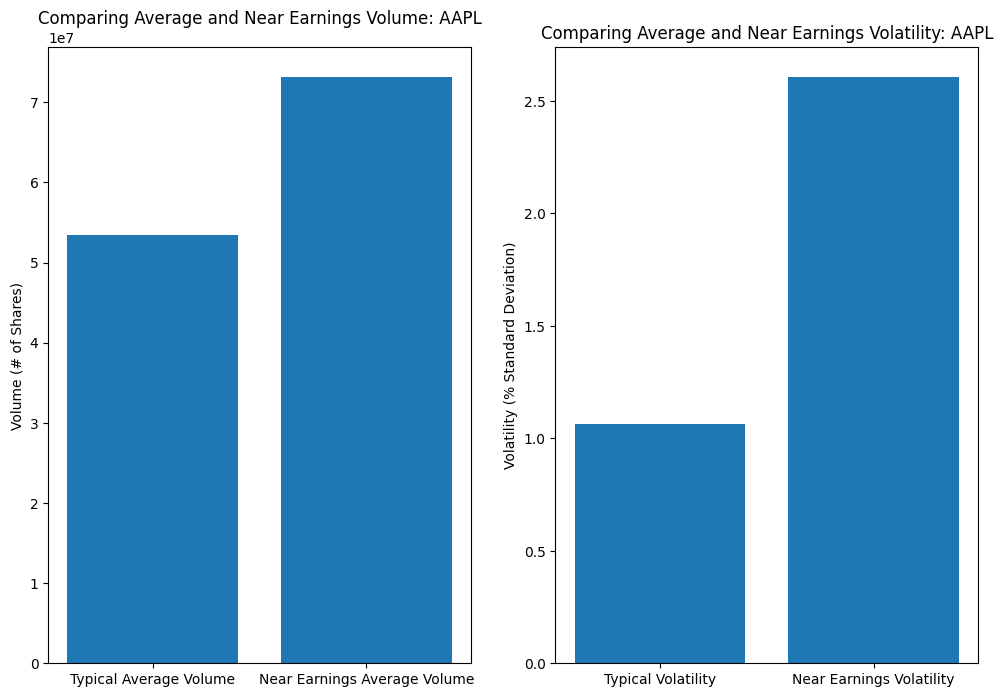

In [3]:
start1='2023-10-01'
end1='2023-11-01'
start2='2024-04-24'
end2='2024-05-05'
voldata = stockdata.loc[:, 'Volume']
plot1 = voldata.loc[start1:end1, 'AAPL'].mean()
plot2 = voldata.loc[start2:end2, 'AAPL'].mean()
fig, (ax1, ax2) = plt.subplots(1,2)
fig.set_size_inches(12, 8)
ax1.set_title("Comparing Average and Near Earnings Volume: AAPL")
ax1.set_ylabel('Volume (# of Shares)')
ax1.bar(['Typical Average Volume', 'Near Earnings Average Volume'], [plot1, plot2])

plot3 = stockdata.loc[:, 'Adj Close'].loc[start1:end1, 'AAPL'].pct_change().std() * 100
plot4 = stockdata.loc[:, 'Adj Close'].loc[start2:end2, 'AAPL'].pct_change().std() * 100
ax2.set_title("Comparing Average and Near Earnings Volatility: AAPL")
ax2.set_ylabel("Volatility (% Standard Deviation)")
ax2.bar(['Typical Volatility', 'Near Earnings Volatility'], [plot3, plot4])

Considering that we want to minimize volatility in order to meet the market, we filter out any stocks that have upcoming earnings or dividend dates:

In [4]:
#fetch the current and cutoff dates
currdate = (datetime.now()).date()
cutoff = (currdate + timedelta(days=14))

for ticker in tickerlist:
    #fetch the relevant dates
    cal = yf.Ticker(ticker).calendar
    #ensure that the yfinance has the dates we want
    div = (cal['Ex-Dividend Date'] if 'Ex-Dividend Date' in cal.keys() else cutoff)
    earnings = (cal['Earnings Date'][1] if len(cal['Earnings Date']) > 1 else cal['Earnings Date'][0])
    #check if there are events in the near future
    if ((earnings > currdate) and (cutoff > earnings)) or ((div > currdate) and (cutoff > div)):
        tickerlist.remove(ticker)
        

## Beta
Beta is a measure of volatility of a security or portfolio compared to the market. A beta of 1.0 indicates that a stock follows the market's returns exactly. In this case, yfinance provides a beta value comparing each stock the S&P500 index. However, as we want to match the average of both the TSX60 and the S&P500, we will calculate beta when compared to the TSX60. Then, we can take the average of the two betas in order to accurately represent the volatility compared to the index used in this assignment.  
  
We can calculate beta using the formula (Covariance(Individual Returns, Market Returns)) / (Variance(Market Returns))

In [5]:
tsxprice = yf.download('XIU.TO', start=startdate, end=enddate)['Adj Close'] #the TSX60 isn't directly tracked on yfinance, so we use XIU.TO (an ETF that mimics the TSX)
beta_dict = {}
closedata = stockdata.loc[:, 'Adj Close']
#pre calculate variance of the TSX index to avoid looped computation
tsxpct = tsxprice.pct_change(fill_method=None)
tsxvar = tsxpct.var().iloc[0]

#calculate beta for each stock
for ticker in tickerlist:
    #prevent any mismatched indexes
    common = closedata[ticker].index.intersection(tsxprice.index)
    closepct = closedata.loc[common, ticker].pct_change(fill_method=None)
    #calculate beta with respect to TSX
    beta1 = closepct.cov(tsxpct.iloc[:,0]) / tsxvar
    #fetch beta with respect to SP500
    beta2 = yf.Ticker(ticker).info.get('beta') 
    beta_dict[ticker] = abs(1.0 - (beta1 + (beta2 if beta2 else beta1)) / 2)

[*********************100%***********************]  1 of 1 completed


In [13]:
#create list to store sorted order
betaSorted = []
print('The stocks sorted by closeness to 1.0 are: ')
for t in sorted(beta_dict, key=beta_dict.get, reverse=False):
    betaSorted.append([t, beta_dict[t]])

print(betaSorted)

The stocks sorted by closeness to 1.0 are: 
[['AIG', 0.007020695717120162], ['UPS', 0.011397209347960846], ['ACN', 0.0386383691313803], ['BK', 0.03901758975673597], ['UNP', 0.06783167805555379], ['AMZN', 0.08500752494154318], ['AAPL', 0.1007978855866547], ['TXN', 0.13161840051857765], ['RY.TO', 0.13576624435176843], ['TD.TO', 0.1390573395716208], ['BLK', 0.2076806381774372], ['AXP', 0.21184866052211548], ['CAT', 0.27272163377029446], ['USB', 0.33476217365251726], ['BA', 0.34273403944820524], ['T.TO', 0.34873368883985123], ['BAC', 0.35531639832553186], ['QCOM', 0.37915760075735117], ['C', 0.40354300495421747], ['PFE', 0.4414248461957153], ['MO', 0.48138634096768906], ['PYPL', 0.48463580104711435], ['LLY', 0.48670362070428497], ['PM', 0.5017539508194088], ['ABT', 0.5170219517840324], ['BMY', 0.5263149808268979], ['ABBV', 0.5529772122598023], ['BIIB', 0.5771153127477764], ['UNH', 0.6018316439694819], ['PEP', 0.6603995287043918], ['MRK', 0.696754625021861], ['PG', 0.7792030122149186], ['CL

## Making the Portfolio
If a market risk occurs during the contest period, it would not only affect the stocks we selected but the market indices as well. Thus, we will focus on limiting diversifiable risk instead. To do this, we will choose to add the maximum number of stocks to our portfolio (i.e. 24) so that if individual companies face issues during the week, any impacts on the overall value of our portfolio will be reduced.

Although the beta of each company deviates further and further from 1 as we go down our list of stocks, we believe that choosing the maximum number possible is still more important because there would be a greater likelihood of highs in certain firms being balanced out by lows in others.

OR IF 12:

Since we want to keep the overall beta of our portfolio as close to the market index as possible, we will choose to add the minimum number of stocks to our portfolio  (i.e. 12). This still provides us with some diversification benefits to limit diversifiable risk while allowing us to target a beta closest to 1. (If a market risk occurs during the contest period, it would not only affect the stocks we selected but the market indices as well, so we can only focus on limiting firm-specific risk.) Since we ordered the stocks from distance to beta of 1, choosing the first 12 stocks on the list will ensure that we are only using the 12 stocks that most closely follow market trends, thus allowing us to best meet the market.

In [25]:
#create dataframe for portfolio and store first 12 stocks on list inside
Portfolio_Final = pd.DataFrame(columns=["Ticker", "Price", "Currency", "Shares", "Value", "Weight"])



#extract the first 12 tickers
tickers = [betaSorted[i][0] for i in range(12)]

#assign the tickers list to a new column in the DataFrame
Portfolio_Final["Ticker"] = tickers

# change index to start at 1
Portfolio_Final.index = range(1, len(Portfolio_Final) + 1)

Portfolio_Final

,Ticker,Price,Currency,Shares,Value,Weight
1,AIG,NaN,NaN,NaN,NaN,NaN
2,UPS,NaN,NaN,NaN,NaN,NaN
3,ACN,NaN,NaN,NaN,NaN,NaN
4,BK,NaN,NaN,NaN,NaN,NaN
5,UNP,NaN,NaN,NaN,NaN,NaN
6,AMZN,NaN,NaN,NaN,NaN,NaN
7,AAPL,NaN,NaN,NaN,NaN,NaN
8,TXN,NaN,NaN,NaN,NaN,NaN
9,RY.TO,NaN,NaN,NaN,NaN,NaN
10,TD.TO,NaN,NaN,NaN,NaN,NaN
